# Predicting Uncertainty

Using the 30 models produced in `4c_Uncertainty_LGBM_model.ipynb`, we will generate an ensemble of 30 predictions. From this ensemble we will produce an uncertainty envelope, and a median prediction.


In [ ]:
import sys
import os
import xarray as xr
import numpy as np
import pandas as pd
from joblib import load
from odc.geo.geobox import zoom_out
from odc.algo import xr_reproject
from datacube.utils.dask import start_local_dask
from odc.geo.xr import assign_crs
import odc.geo.xr
# from dask.distributed import Client,Scheduler
# from dask_jobqueue import SLURMCluster

sys.path.append('/g/data/os22/chad_tmp/NEE_modelling/')
from collect_prediction_data import round_coords#, collect_prediction_data, 

sys.path.append('/g/data/os22/chad_tmp/dea-notebooks/Tools/')
from dea_tools.classification import predict_xr, HiddenPrints

In [ ]:
# cluster = SLURMCluster(processes=2, cores=2, memory="47GB", walltime='02:00:00')
# client = Client(cluster)
# cluster.scale(cores=18)

client = start_local_dask(mem_safety_margin='2Gb')
client

## Analysis Parameters

In [4]:
var = 'GPP'
suffix='20230109'
results_path = '/g/data/os22/chad_tmp/NEE_modelling/results/predictions_uncertainty/'+var+'/'
models_folder = '/g/data/os22/chad_tmp/NEE_modelling/results/models_uncertainty/'+var+'/'
features_list = '/g/data/os22/chad_tmp/NEE_modelling/results/variables_'+suffix+'.txt'

t1, t2='2003','2021'
rescale=False

## Get paths to models

In [ ]:
model_list = [file for file in os.listdir(models_folder) if file.endswith(".joblib")]

## Open predictor data

In [ ]:
data = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/results/prediction_data/data_5km.nc')
mask = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/results/prediction_data/mask_5km.nc')

### Check training and prediction variable order

In [ ]:
train_vars = list(pd.read_csv(features_list))[0:-1]
train_vars=[i[:-3] for i in train_vars]

data = data[train_vars]

if train_vars == list(data.data_vars):
    print('Variables match, n: ', len(data.data_vars))
else:
    raise ValueError('Variables dont match')

### Predict each time-step seperately

- TO DO: fix timesteps that come back from `predict_xr`

In [ ]:
#mask urban
mask1 = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/urban_mask_1km.nc')
mask1 = xr_reproject(mask1, geobox=data.odc.geobox.compat, resampling='mode')
mask1=round_coords(mask1)
mask1 = mask1.rename({'latitude':'y', 'longitude':'x'})

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Loop through the 30 models
for m in model_list:
    name = m.split('.')[0]
    
    if os.path.exists(results_path+name+'.nc'):
        print('skipping model '+name)
        continue
    
    print('Model: ', name)
    
    model = load(models_folder+m).set_params(n_jobs=1)
    
    results = []
    i=0
    #loop through the time-steps
    for i in range(0, len(data.time)): 
        print("  {:03}/{:03}\r".format(i + 1, len(range(0, len(data.time)))), end="")

        with HiddenPrints():
            predicted = predict_xr(model,
                                data.isel(time=i),
                                proba=False,
                                clean=True,
                                  ).compute()

        predicted = predicted.Predictions.where(~mask.isel(time=i).compute())
        predicted['time'] = data.isel(time=i).time.values
        results.append(predicted.astype('float32'))
        i+=1 
        
    ds = xr.concat(results, dim='time').sortby('time').rename(var).astype('float32')
    
    #mask urban
    ds = ds.where(~mask1).astype('float32')

    #save results
    ds.to_netcdf(results_path+name+'.nc')
    

## Combine all the predictions

Ran 30 predictions, now its time to open and plot all of them.

Then we extract the interquartile range

Save as a netcdf to faciliate quick plotting later

In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
!rm -r -f /g/data/os22/chad_tmp/NEE_modelling/results/predictions_uncertainty/GPP/.ipynb_checkpoints

In [5]:
base = '/g/data/os22/chad_tmp/NEE_modelling/results/predictions_uncertainty/'+var+'/'
files = os.listdir(base)

In [6]:
pred_filepaths = [base+i for i in files]

### plot all results

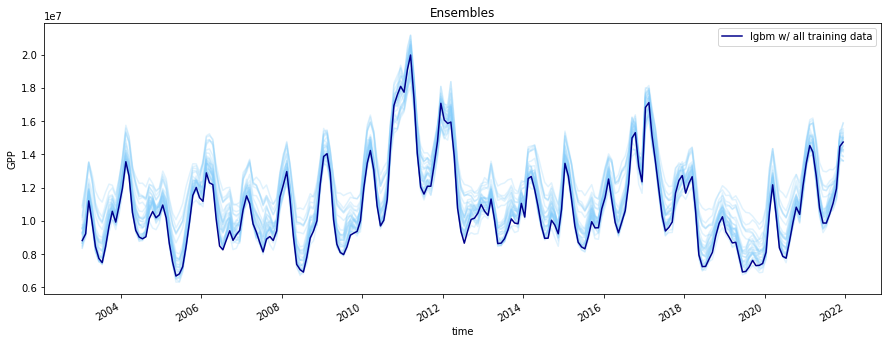

In [12]:
fig,ax = plt.subplots(1,1, figsize=(15, 5))
for pred in pred_filepaths:
    ds=xr.open_dataarray(pred)
    ds.sum(['x','y']).plot(ax=ax, alpha=0.25, c='lightskyblue')

ds = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/results/predictions/'+var+'_2003_2021_5km_LGBM_'+suffix+'.nc')
ds.sum(['x','y']).plot(ax=ax, c='darkblue', label='lgbm w/ all training data')
# plt.axhline(0, c='grey', linestyle='--')
plt.title('Ensembles')
ax.legend()

### Find interquantile range

In [13]:
arrs=[]
for pred in pred_filepaths:
    ds=xr.open_dataarray(pred)
    arrs.append(ds.rename(pred[-8:-3]))

In [14]:
ds = xr.merge(arrs)
ds = ds.to_array()

In [15]:
import sys
sys.path.append('/g/data/os22/chad_tmp/NEE_modelling/')
from _percentile import xr_quantile

In [16]:
ds = xr_quantile(ds, quantiles=[0.25, 0.50, 0.75], nodata=np.nan)

Text(0.5, 1.0, 'Uncertanity modelling, quantiles of ensembles')

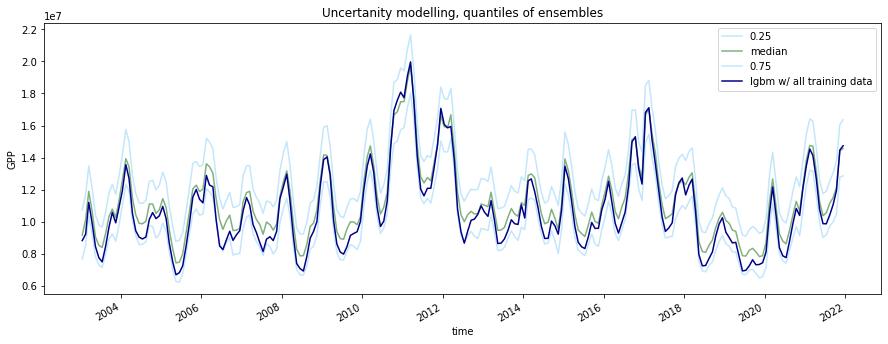

In [27]:
fig,ax = plt.subplots(1,1, figsize=(15, 5))
ds.sel(quantile=0.25).sum(['x','y']).plot(ax=ax, alpha=0.5, c='lightskyblue', label='0.25')
ds.sel(quantile=0.50).sum(['x','y']).plot(ax=ax, alpha=0.5, c='darkgreen', label='median')
ds.sel(quantile=0.75).sum(['x','y']).plot(ax=ax, alpha=0.5, c='lightskyblue', label='0.75')

da = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/results/predictions/'+var+'_2003_2021_5km_LGBM_'+suffix+'.nc')
da.sum(['x','y']).plot(ax=ax, c='darkblue', label='lgbm w/ all training data')
# plt.axhline(0, c='grey', linestyle='--')
ax.legend()
plt.title('Uncertanity modelling, quantiles of ensembles')

In [24]:
ds = ds.rename({'band':var+'_quantiles'}).to_array().squeeze().drop('variable')
ds.attrs['nodata']=np.nan

In [25]:
ds.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/results/predictions/'+var+'_2003_2021_5km_LGBM_quantiles_'+suffix+'.nc')

In [ ]:
# ds.sel(quantile=0.75).isel(time=1).plot.imshow(size=10, robust=True)

### Map per-pixel deviation in predictions

In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from odc.algo import xr_reproject
from odc.geo.xr import assign_crs
import odc.geo.xr


In [2]:
# from dask.distributed import Client,Scheduler
# from dask_jobqueue import SLURMCluster
# cluster = SLURMCluster(processes=2, cores=2, memory="47GB", walltime='02:00:00')
# client = Client(cluster)
# cluster.scale(cores=18)

from datacube.utils.dask import start_local_dask
client = start_local_dask(mem_safety_margin='2Gb')


In [3]:
client#s.shutdown()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 1
Total threads: 16,Total memory: 44.92 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37033,Workers: 1
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 44.92 GiB
Comm: tcp://127.0.0.1:42613,Total threads: 16
Dashboard: /proxy/33749/status,Memory: 44.92 GiB
Nanny: tcp://127.0.0.1:44413,


In [4]:
var = 'GPP'
suffix='20230109'

In [5]:
base = '/g/data/os22/chad_tmp/NEE_modelling/results/predictions_uncertainty/'+var+'/'
files = os.listdir(base)

In [6]:
pred_filepaths = [base+i for i in files]

### Convert to PgC/year

In [7]:
geobox = xr.open_dataarray(pred_filepaths[0]).odc.geobox
grid = geobox.to_crs('EPSG:3577')

In [8]:
i=0
arrs=[]
for pred in pred_filepaths:
    print(" {:03}/{:03}\r".format(i+1, len(pred_filepaths)), end="")
    ds=xr.open_dataarray(pred)
    ds = xr_reproject(ds, geobox=grid.compat, resampling='bilinear')
    area_per_pixel = ds.geobox.resolution[1]**2
    ds = ds * area_per_pixel * 1e-15 * 12
    ds = ds.groupby('time.year').sum().mean('year')
    arrs.append(ds.rename(pred[-8:-3]))
    i+=1

In [9]:
ds = xr.merge(arrs)
ds = ds.to_array()

In [10]:
median = ds.median(dim='variable')
dev = np.abs(ds-median)
mad = dev.median(dim='variable').compute()

In [11]:
# best = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/results/predictions/NEE_2003_2021_5km_LGBM.nc')
cv = mad/median

In [12]:
median.attrs['units']='PgC/year'
mad.attrs['nodata']=np.nan
mad = mad.rename('MAD')
mad.attrs['units']='PgC/year'
mad = mad.where(mad>0)

In [13]:
mad.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/results/MAD_uncertainty_'+var+'_PgCyear_'+suffix+'.nc')

### Number of models that show a mean net sink

In [ ]:
count_of_sinks = xr.where(ds<0, 1, 0)
count_of_sources = xr.where(ds>0, 1, 0)

In [ ]:
count_of_sources = count_of_sources.sum('variable')
count_of_sources = count_of_sources / len(ds.variable)

In [ ]:
count_of_sinks = count_of_sinks.sum('variable')
count_of_sinks = count_of_sinks / len(ds.variable)
# count_of_sinks = count_of_sinks.where(~mask)

In [ ]:
frac_of_agreement = xr.where(median<0, count_of_sinks, count_of_sources)
frac_of_agreement = frac_of_agreement.where(frac_of_agreement>0)

### Plot all of the dataset just produced

In [ ]:
fontsize=20
fig, ax = plt.subplots(2,2, figsize=(25,20), sharey=True, sharex=True)
im = median.where(median!=0).plot.imshow(ax=ax[0,0], robust=True, cmap='RdBu_r',add_labels=False)

mad.plot.imshow(ax=ax[0,1], robust=True, cmap='cividis', add_labels=False)
np.abs(cv).plot.imshow(ax=ax[1,0], vmax=3, vmin=0, cmap='plasma', add_labels=False)
frac_of_agreement.plot.imshow(ax=ax[1,1], cmap='viridis_r', vmax=1, vmin=0.5, add_labels=False)
# plt.gcf().axes[-2]..label.set_fontsize(20)
aa = plt.gcf().axes
aa[-4].tick_params(labelsize=fontsize) 
aa[-3].tick_params(labelsize=fontsize) 
aa[-2].tick_params(labelsize=fontsize) 
aa[-1].tick_params(labelsize=fontsize) 
aa[-4].ticklabel_format(style='sci', scilimits=[-4, 6])
for a in ax.ravel():
    a.set_yticklabels([])
    a.set_xticklabels([])

ax[0,0].set_title('Median of Annual Mean NEE Ensembles', fontsize=fontsize)
ax[0,1].set_title('Median Absolute Deviation in Annual Mean NEE Ensembles', fontsize=fontsize)
ax[1,0].set_title('Absolute Coefficient of Variation (MAD/Median)', fontsize=fontsize)
ax[1,1].set_title("Fraction of Model Ensemble Members where Annual NEE Sign Agrees",  fontsize=fontsize)
plt.tight_layout();
plt.savefig('/g/data/os22/chad_tmp/NEE_modelling/results/figs/Uncertainty_perpixel_'+var+'_'+suffix+'.png', bbox_inches='tight')

In [14]:
fontsize=20
fig, ax = plt.subplots(1,3, figsize=(24,10), sharey=True, sharex=True)
im = median.where(median!=0).plot.imshow(ax=ax[0], robust=True, cmap='RdBu_r',add_labels=False)

mad.plot.imshow(ax=ax[1], robust=True, cmap='cividis', add_labels=False)
cv.plot.imshow(ax=ax[2], vmax=3, vmin=0, cmap='plasma', add_labels=False)
plt.gcf().axes[-2]..label.set_fontsize(20)
aa = plt.gcf().axes
aa[-4].tick_params(labelsize=fontsize) 
aa[-3].tick_params(labelsize=fontsize) 
aa[-2].tick_params(labelsize=fontsize) 
aa[-1].tick_params(labelsize=fontsize) 
aa[-4].ticklabel_format(style='sci', scilimits=[-4, 6])
for a in ax.ravel():
    a.set_yticklabels([])
    a.set_xticklabels([])

ax[0].set_title('Median of Annual Mean NEE Ensembles', fontsize=fontsize)
ax[1].set_title('Median Absolute Deviation in Annual Mean NEE Ensembles', fontsize=fontsize)
ax[2].set_title('Absolute Coefficient of Variation (MAD/Median)', fontsize=fontsize)
plt.tight_layout();
# plt.savefig('/g/data/os22/chad_tmp/NEE_modelling/results/figs/Uncertainty_perpixel_'+var+'_'+suffix+'.png', bbox_inches='tight')

SyntaxError: invalid syntax (3376939987.py, line 7)